In [1]:
# history of elimination, comparison of different elimination 
# trajectories/stategies

from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair

from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs

# for animation
from PIL import Image
import imageio
import glob


In [2]:
%matplotlib widget

In [3]:
settings = {
    'path_to_SAMMY_exe': '/home/fire/SAMMY/sammy/build/install/bin/sammy',
    'path_to_SAMMY_temps': './sammy_temps/',
    'keep_runDIR_SAMMY': True,
    'shell_SAMMY': 'bash',
    'running_path': os.getcwd(), #current_dir
    'printout': True
}

savefolder = './data/'
savefolder = './data_new/'

# saving images
anim_save_dir = savefolder+'anim/'

# Ensure the folder exists
if not os.path.exists(anim_save_dir ):
    os.makedirs(anim_save_dir)

all_histories_data = {
    '0_asg_80_red_50_greedy_sdf_15':{
        'dataset_pkl': 'dataset_80_red_50_greedy_True_er[202_227]_chi2allowed_0_allspingr_sdf_15.pkl',
        'hist_pkl': 'hist_80_red_50_greedy_True_er[202_227]_chi2allowed_0_allspingr_sdf_15.pkl'
    },

    '0_asg_60_red_40_greedy_sdf_15':{
        'dataset_pkl': 'dataset_sf_40_greedy_True_er[202_227]_chi2allowed_0_allspingr_sdf_15.pkl',
        'hist_pkl': 'hist_sf_40_greedy_True_er[202_227]_chi2allowed_0_allspingr_sdf_15.pkl'
    },

    '0_asg_60_red_15_greedy_sdf_15':{
        'dataset_pkl': 'dataset_sf_15_greedy_True_er[202_227]_chi2allowed_0_allspingr_sdf_15.pkl',
        'hist_pkl': 'hist_sf_15_greedy_True_er[202_227]_chi2allowed_0_allspingr_sdf_15.pkl'
    },
    

    

    

}

fig_size_data = (9,8)
fig_size_hist = (4,8)

fig_size_SF = (8,6)
fig_size_XS = (8,6)

colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]


In [4]:
chi2_labels = []
allexp_data = {}

for key, value in all_histories_data.items():

    chi2_allowed = key
    dataset_pkl = value['dataset_pkl']
    hist_pkl = value['hist_pkl']

    energy_range, datasets, covariance_data, experiments, true_chars, Ta_pair, hist, elim_OPTS_used = elim_addit_funcs.load_all(savefolder=savefolder,
                          hist_pkl_name=hist_pkl,
                          dataset_pkl_name=dataset_pkl)
    
    allexp_data[f'{key}'] = {
        'energy_range': energy_range,
        'datasets': datasets,
        'experiments': experiments,
        'covariance_data': covariance_data,
        'true_chars': true_chars,
        'Ta_pair': Ta_pair,
        'hist': hist,
        'elim_opts': elim_OPTS_used
    }

# print(allexp_data['28']['hist'].elimination_history[30]['total_time'])

In [5]:
# model1_key = 0
# model2_key = '0_asg_sf_35'

# model2_key = '0_asg_sf_50'
# model1_key = '0_asg_sf_35'

model1_key = '0_asg_60_red_15_greedy_sdf_15'
model2_key = '0_asg_60_red_40_greedy_sdf_15'
model3_key = '0_asg_60_red_15_greedy_sdf_15'


compare_keys = [f'{model1_key}', f'{model2_key}' ]

comp_level = 10

In [6]:
allexp_data[f'{model1_key}']['Ta_pair'].spin_groups


{'3.0': {'J_ID': 1,
  '<D>': 8.79,
  '<Gn>': 46.5,
  'n_dof': 1,
  '<Gg>': 64.0,
  'g_dof': 1000,
  'D01': 0.9943384234177864,
  'D99': 21.284662911191237,
  'Gn01': 0.007304585392801135,
  'Gn99': 308.52269194748646,
  'Gg01': 57.53039660349525,
  'Gg99': 70.84601563854191,
  'Gt01': 57.53770118888805,
  'Gt99': 379.3687075860284},
 '4.0': {'J_ID': 2,
  '<D>': 4.99,
  '<Gn>': 35.5,
  'n_dof': 1,
  '<Gg>': 64.0,
  'g_dof': 1000,
  'D01': 0.5644765338856377,
  'D99': 12.083102153224605,
  'Gn01': 0.005576618955794415,
  'Gn99': 235.53882933625312,
  'Gg01': 57.53039660349525,
  'Gg99': 70.84601563854191,
  'Gt01': 57.53597322245104,
  'Gt99': 306.38484497479504}}

In [36]:
# make a solution comparison table

importlib.reload(elim_addit_funcs)

# print('Elim opts used:')
# print(allexp_data[f'{model1_key}']['elim_opts'])

# model
model_to_show = f'{model2_key}'

table = elim_addit_funcs.create_solutions_comparison_table_from_hist(hist = allexp_data[model_to_show]['hist'],
                                                Ta_pair = allexp_data[model_to_show]['Ta_pair'],
                     datasets =  allexp_data[model_to_show]['datasets'],
                     experiments =  allexp_data[model_to_show]['experiments'],
                     covariance_data =  allexp_data[model_to_show]['covariance_data'],
                     true_chars = allexp_data[model_to_show]['true_chars'],
                     settings=settings,
                     energy_grid_2_compare_on = allexp_data[model_to_show]['energy_range']
                     )


Completed Job: 1
Energy grid for analysis: [202, 227]
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
             E           Gg        Gn1  varyE  varyGg  varyGn1  J_ID        gn
0   200.000000    28.333205  63.682840    0.0     1.0      1.0   1.0  2.827618
1   204.724433    64.270447   0.919828    1.0     0.0      1.0   2.0  0.341820
2   204.711558    64.069213   0.540031    1.0     0.0      1.0   1.0  0.261907
3   204.908572    64.134371   0.238477    1.0     0.0      1.0   2.0  0.174087
4   208.383834    62.603805   1.828344    1.0     0.0      1.0   1.0  0.484058
5   208.392219    63.853958   1.495265    1.0     0.0      1.0   2.0  0.437755
6   208.881250    63.370184   0.870049    1

In [ ]:
# for step in allexp_data[f'{model1_key}']['hist'].elimination_history:
#     print(step)

In [37]:
cols_to_show = table.columns
print(cols_to_show)

Index(['AT', 'N_res', 'N_res_joint_LL', 'passed', 'sum_chi2', 'chi2_s', 'SSE',
       'sum_NLLW', 'sum_NLL_Gn1', 'sum_NLL_Gg', 'OF_alt1', 'OF_alt3',
       'sum_NLLW_al', 'sum_NLL_gn_normal', 'OF_alt4', 'SF_Gn1', 'SF_Gg',
       'AICc', 'BIC', 'delta_AICc_best', 'delta_BIC_best', 'delta_chi2_prev',
       'delta_chi2_best'],
      dtype='object')


In [38]:
cols_to_show= ['AT', 'N_res', 'N_res_joint_LL', 'sum_chi2', 'SSE', 'sum_NLL_gn_normal', 'sum_NLLW_al', 'OF_alt4', 'OF_alt3']
#cols_to_show = table.columns
table[cols_to_show]

,AT,N_res,N_res_joint_LL,sum_chi2,SSE,sum_NLL_gn_normal,sum_NLLW_al,OF_alt4,OF_alt3
0,False,41,-1416.792837,899.8473,2341.436547,113.841918,145.764231,1419.059597,1381.532234
1,False,40,-1416.792837,879.5998,2285.320717,113.844444,148.657458,1404.603606,1359.817671
2,False,39,-1416.792837,875.6779,2286.339183,113.841677,151.495079,1406.351412,1352.042171
3,False,38,-1416.792837,874.2348,2289.714740,113.841151,150.424554,1402.766210,1340.269531
4,False,37,-1416.792837,873.8445,2295.265292,113.840957,142.309147,1386.144708,1316.056973
5,False,36,-1416.792837,872.9440,2297.321975,113.840624,142.833880,1386.293008,1306.905577
6,False,35,-1416.792837,873.9864,2296.424309,113.840434,137.297169,1376.261606,1287.732836
7,False,34,-1416.792837,872.9127,2301.652075,113.840143,133.682374,1367.957733,1272.023445
8,False,33,-1416.792837,875.4683,2301.487520,113.839911,129.986725,1363.121572,1258.436364
9,False,32,-1416.792837,875.4031,2293.568779,113.839881,126.121908,1355.326678,1241.496544


/tmp/ipykernel_6885/2493964633.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SSE_diff'] = np.abs(filtered_df['SSE'] - true_sse)


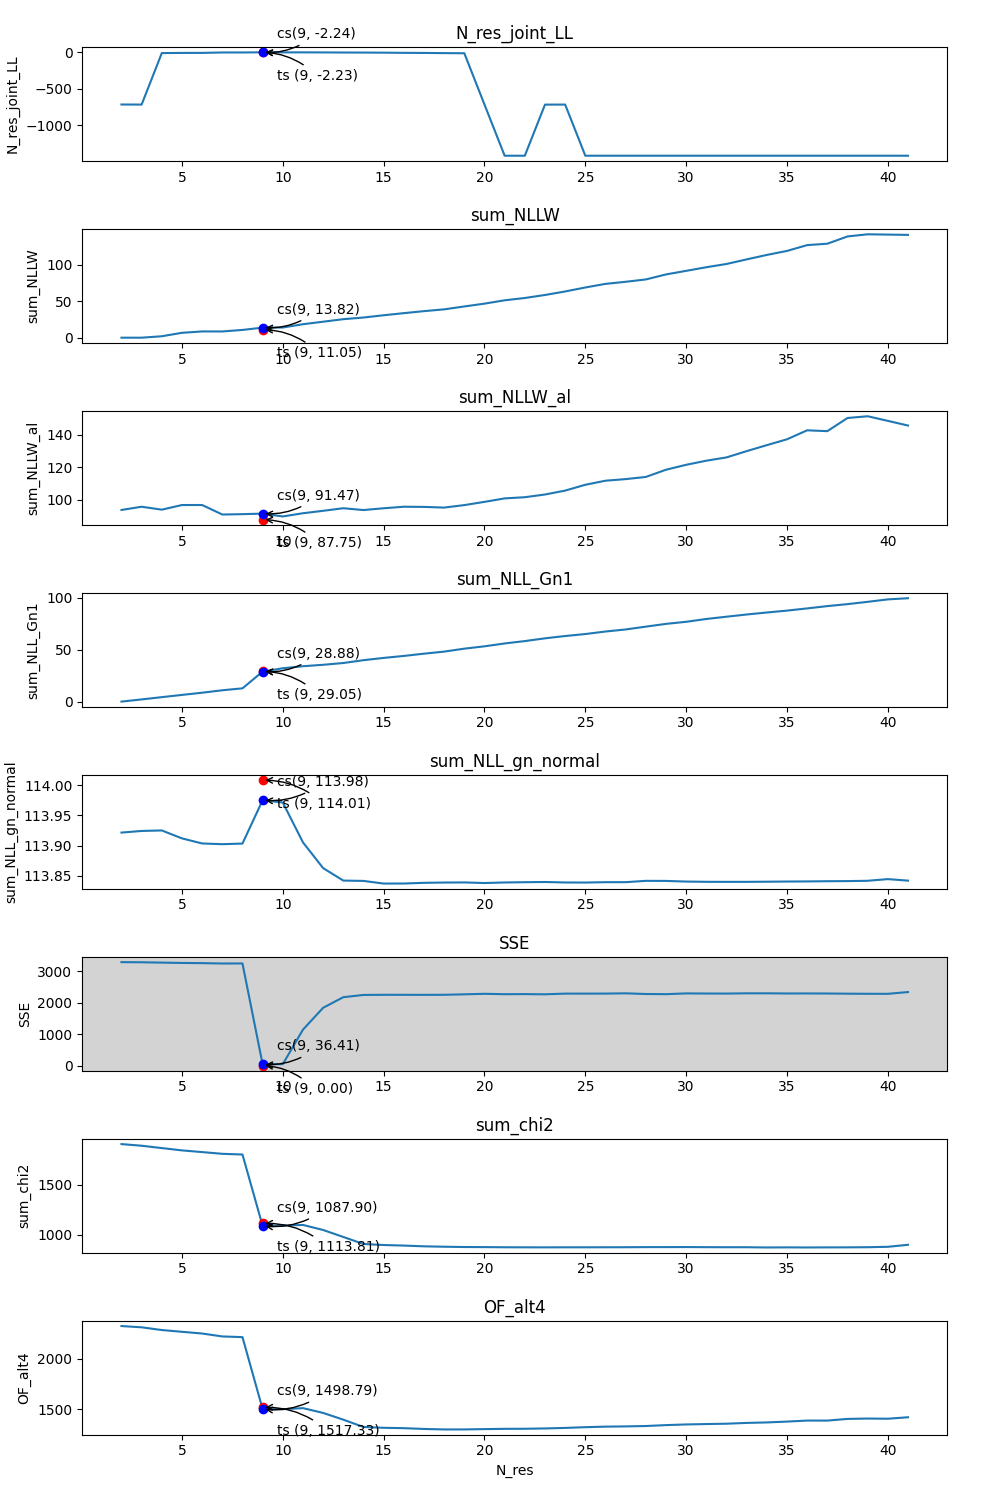

In [39]:
import matplotlib.pyplot as plt

filtered_df = table[table['AT'] == False]

# Find the row where AT is True
true_solution_row = table[table['AT'] == True].iloc[0]

# closest to the true by SSE# Find the closest solution by SSE
true_sse = true_solution_row['SSE']
filtered_df['SSE_diff'] = np.abs(filtered_df['SSE'] - true_sse)

closest_row = filtered_df.loc[filtered_df['SSE_diff'].idxmin()]

# List of columns to plot against N_res
columns_to_plot = ['N_res_joint_LL', 'sum_NLLW',  'sum_NLL_Gn1', 'sum_chi2', 'OF_alt3', 'SSE', 'SF_Gn1', 'SF_Gg', 'AICc', 'BIC']
columns_to_plot = ['N_res_joint_LL', 'sum_NLLW', 'sum_NLLW_al',  'sum_NLL_Gn1', 'sum_NLL_gn_normal', 'SSE', 'sum_chi2', 'OF_alt4' ]
# Columns to highlight
columns_to_highlight = ['SSE', 'SF_Gn1', 'SF_Gg']

# Plotting
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 15))
fig.tight_layout(pad=3.0)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(filtered_df['N_res'], filtered_df[column])
    #axes[i].set_xlabel('N_res')
    axes[i].set_ylabel(column)
    axes[i].set_title(f'{column}')

    if column in columns_to_highlight:
        axes[i].set_facecolor('lightgrey')  # Set background color for highlighted plots

    # Plot and annotate the true solution
    true_value = true_solution_row[column]
    n_res_true = true_solution_row['N_res']
    axes[i].plot(n_res_true, true_value, 'ro')  # Red dot for the true solution
    axes[i].annotate(f'ts ({n_res_true}, {true_value:.2f})',
                    xy=(n_res_true, true_value),
                    xytext=(10, -20),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Plot and annotate the closest solution
    closest_value = closest_row[column]
    n_res_closest = closest_row['N_res']
    axes[i].plot(n_res_closest, closest_value, 'bo')  # Blue dot for the closest solution
    axes[i].annotate(f'cs({n_res_closest}, {closest_value:.2f})',
                    xy=(n_res_closest, closest_value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
# Only label x-axis on the last subplot
axes[-1].set_xlabel('N_res')

# Enable x-axis ticks on all subplots
for ax in axes:
    ax.tick_params(axis='x', which='both', bottom=True)

# Adjust layout to be more compact
plt.subplots_adjust(hspace=0.6)

plt.show()


In [ ]:
# Rank each column and add rankings to the DataFrame
for column in columns_to_highlight:
    # Create a new column name for the ranking
    rank_column_name = f'{column}_Rank'

    # Compute rankings in descending order (1 is the highest rank)
    table[rank_column_name] = table[column].rank(ascending=True, method='min')

table

In [ ]:
# plot history

fig = elim_addit_funcs.plot_history(allexp_data = allexp_data, 
                                    show_keys = compare_keys, 
                                    settings = settings,
                   fig_size = fig_size_hist, 
                   max_level = comp_level, 
                   title = 'Steps tracking')

fig.show()

In [ ]:
# # times for elimination - for each level and cumulatively

# levels_times = elim_addit_funcs.get_level_times(allexp_data: dict, 
#                  show_keys: list,
#                  settings: dict, 
#                  fig_size: tuple = (6, 10), 
#                  max_level: int = None,
#                  title : str = '')

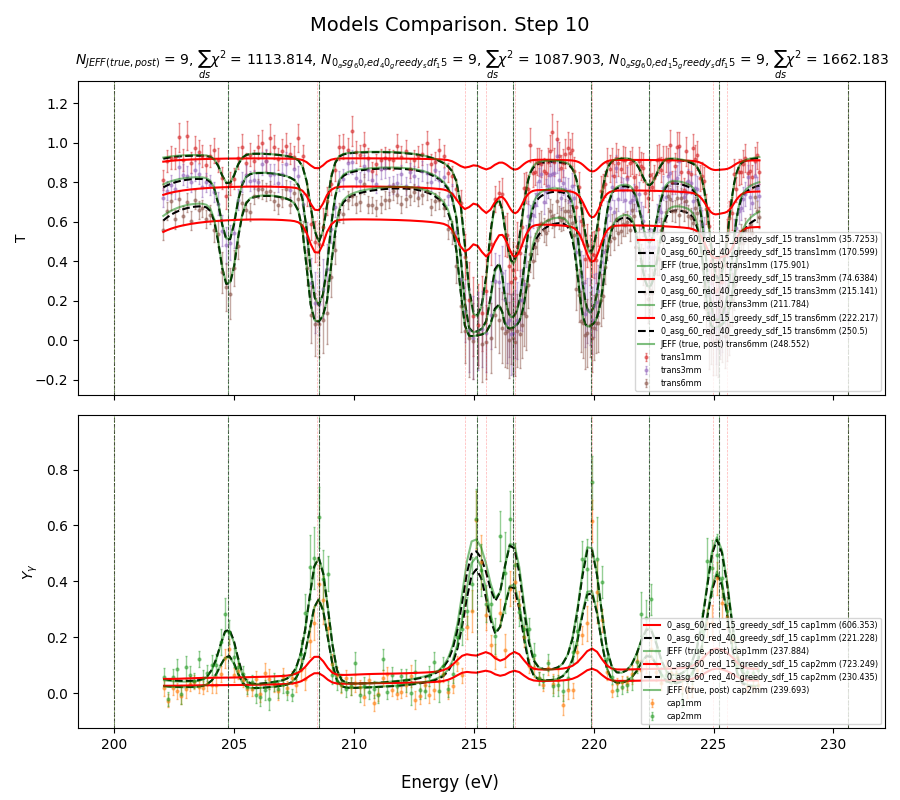

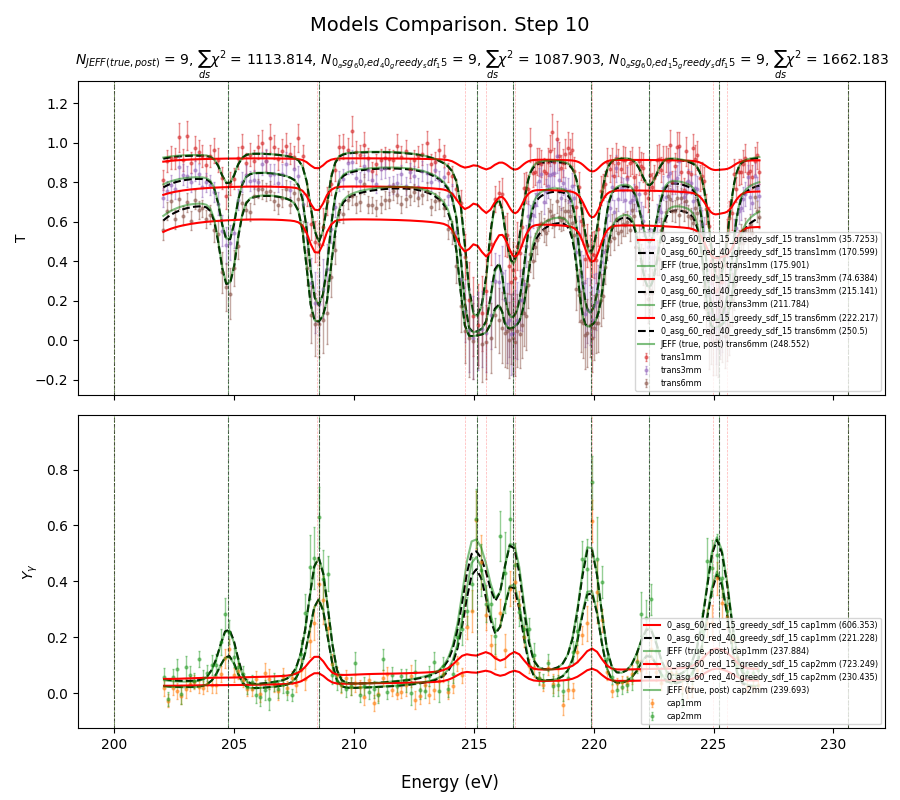

In [41]:
model1 = allexp_data[f'{model1_key}']['hist'].elimination_history[comp_level]['selected_ladder_chars']
model2 = allexp_data[f'{model2_key}']['hist'].elimination_history[comp_level]['selected_ladder_chars']

fig = elim_addit_funcs.plot_datafits(datasets, experiments, 
    fits=model1.pw_post, fits_chi2=model1.chi2_post, f_model_name=f'{model1_key}', f_color='red',
    priors=model2.pw_post, priors_chi2=model2.chi2_post, pr_model_name=f'{model2_key}', pr_color='black',

    true=true_chars.pw_post, true_chi2 = true_chars.chi2_post, t_model_name ='JEFF (true, post)', t_color='green',
        true_pars = true_chars.par_post,
        fit_pars = model1.par_post, 
        prior_pars = model2.par_post,

    title = f'Models Comparison. Step {comp_level}',
    show_spingroups = False,
    fig_size = fig_size_data
    )

fig.show()

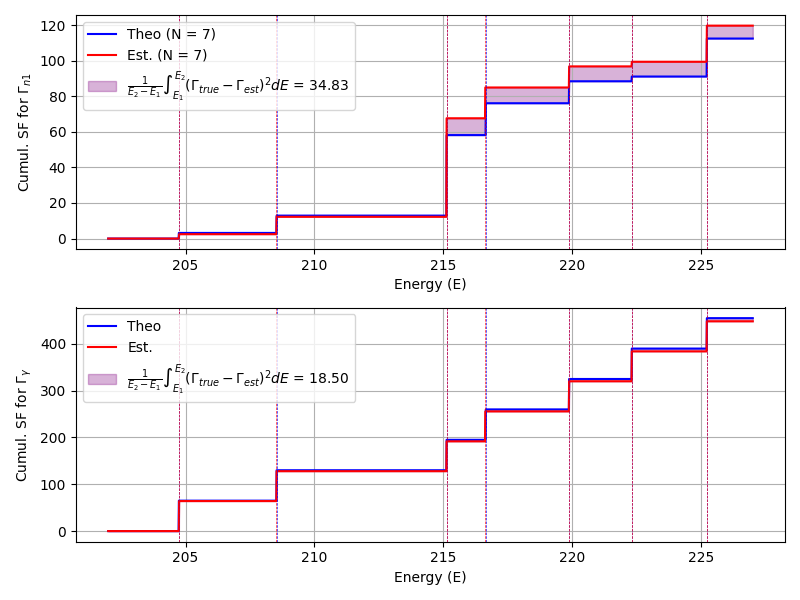

In [42]:
SSE_Gg, SSE_Gn1, SSE_sf_fig = elim_addit_funcs.calc_strength_functions(
        theoretical_df = true_chars.par_post, 
        estimated_df = model2.par_post, 
        energy_range = allexp_data[model_to_show]['energy_range'], 
        fig_size=fig_size_SF, 
        create_fig=True,
        )

Completed Job: 1


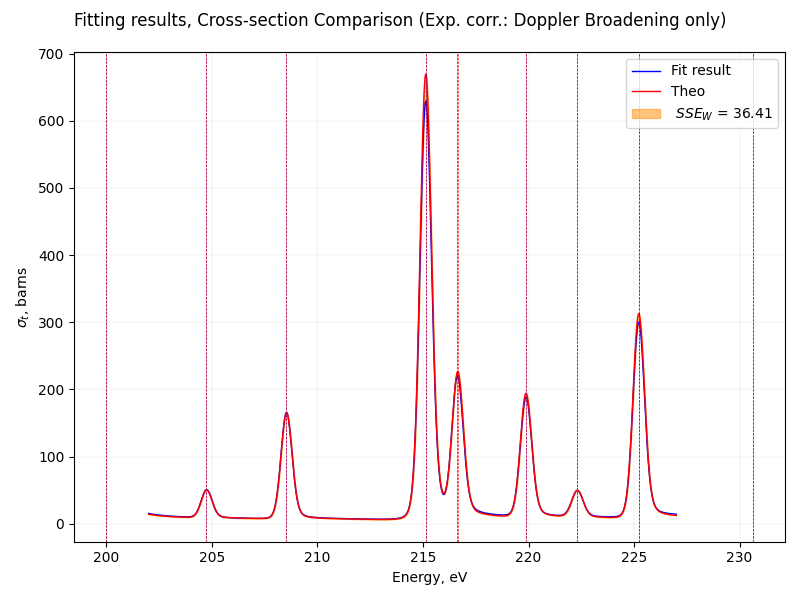

In [43]:
# xs to show
from ATARI.utils.misc import fine_egrid

energy_grid = fine_egrid(energy = allexp_data[model_to_show]['energy_range'])

df_est, df_theo, resid_matrix, SSE_dict, xs_figure = elim_addit_funcs.calc_all_SSE_gen_XS_plot(
                        est_ladder = allexp_data[model_to_show]['hist'].elimination_history[comp_level]['selected_ladder_chars'].par_post,
                        theo_ladder = true_chars.par_post,
                        Ta_pair = Ta_pair,
                        settings = settings,
                        energy_grid = energy_grid,
                        reactions_SSE = ['capture', 'elastic'],
                        fig_size = fig_size_XS,
                        calc_fig = True,
                        fig_yscale='linear'
                )

In [ ]:
# check what model in compare models has lower number of resonances

# # printout all models keys.
# for model_key in compare_keys:
#     print(allexp_data[model_key]['hist'].elimination_history.keys())

# Step 1: Find the model with the smallest number of resonances
resonance_counts = {}
for model_key in compare_keys:
    elimination_keys = allexp_data[model_key]['hist'].elimination_history.keys()
    resonance_counts[model_key] = len(elimination_keys)

# Identify the model with the least resonances
model_with_least_resonances = min(resonance_counts, key=resonance_counts.get)
least_resonances_keys = set(allexp_data[model_with_least_resonances]['hist'].elimination_history.keys())

# Step 2: Check that all keys from the model with the least resonances are present in all other models
keys_aligned = all(least_resonances_keys.issubset(set(allexp_data[model_key]['hist'].elimination_history.keys())) for model_key in compare_keys)

# Print results
print(f"Model with the least number of resonances: {model_with_least_resonances}")
print('Keys in history:')
print(allexp_data[model_with_least_resonances]['hist'].elimination_history.keys())
if keys_aligned:
    print("All keys from the model with the least resonances are present in all other models.")
else:
    print("Not all keys from the model with the least resonances are present in other models.")



In [ ]:
# cycle of images creation

out_images = []

for step in allexp_data[model_with_least_resonances]['hist'].elimination_history:
    print(step)

    model1 = allexp_data[f'{model1_key}']['hist'].elimination_history[step]['selected_ladder_chars']
    model2 = allexp_data[f'{model2_key}']['hist'].elimination_history[step]['selected_ladder_chars']

    # paths to save figures
    model_comp_path = anim_save_dir + f'model_comp_{model1_key}_{model2_key}_step_{step}.png'
    chi2_hist_path = anim_save_dir + f'chi2_hist_{model1_key}_{model2_key}_step_{step}.png'
    combined_image_path = anim_save_dir + f'combined_{model1_key}_{model2_key}_step_{step}.png'

    fig = elim_addit_funcs.plot_datafits(datasets, experiments, 
        fits=model1.pw_post, fits_chi2=model1.chi2_post, f_model_name=f'{model1_key}', f_color='red',
        priors=model2.pw_post, priors_chi2=model2.chi2_post, pr_model_name=f'{model2_key}', pr_color='black',

        true=true_chars.pw_post, true_chi2 = true_chars.chi2_post, t_model_name ='JEFF (true, post)', t_color='green',
            true_pars = true_chars.par_post,
            fit_pars = model1.par_post, 
            prior_pars = model2.par_post,

        title = f'Models Comparison. Step {step}',
        show_spingroups = False,
        fig_size = fig_size_data
        )
    
    fig.savefig(fname = model_comp_path)

    # get the plots of history for this step
    fig_hist = elim_addit_funcs.plot_history(allexp_data = allexp_data,
                            show_keys = compare_keys,
                            settings=settings,
                            fig_size = fig_size_hist,
                            max_level = step,
                            title='Steps tracking',
                            folder_to_save=anim_save_dir)
    
    fig_hist.savefig(fname = chi2_hist_path)

    # combine both images into one left+right (left - model_comp_step, right - chi2_hist_step_)
    image1 = Image.open(model_comp_path)
    image2 = Image.open(chi2_hist_path)

    # Determine the total width and max height of the combined image
    total_width = image1.width + image2.width
    max_height = max(image1.height, image2.height)

    # Create a new blank image with the correct size
    combined_image = Image.new('RGB', (total_width, max_height))

    # Paste the two images into the combined image
    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.width, 0))

    # Save the combined image
    combined_image.save(combined_image_path)
    out_images.append(combined_image_path)
    print(f'saved {combined_image_path}')

    # delete intermediate images
    # del model_comp_path and chi2_hist_path
    os.remove(model_comp_path)
    os.remove(chi2_hist_path)

In [ ]:
def create_animation(pattern: str,  
                     output_name: str,
                     anim_save_dir: str,
                     out_images: list = [],
                     additional_start_images: list =[], 
                     additional_end_images: list =[], 
                     start_duration: int = 3,
                     intermediate_duration: int = 2,
                     end_duration: int = 2):
    
    """Create an animation based on the specified parameters."""
    print('pattern', pattern)

    # If we don't have any data on out_images, parse the directory
    if len(out_images) == 0:
        path_to_search = os.path.join(anim_save_dir, pattern)

        matched_files = glob.glob(path_to_search)

        #matched_files.sort(key=lambda f: int(os.path.basename(f).split('_')[2]), reverse=True)
        matched_files.sort(key=lambda f: int(os.path.basename(f).split('step_')[-1].split('.png')[0]), reverse=True)

        out_images = matched_files
    
    # Convert durations to milliseconds
    start_duration_ms = start_duration * 1000
    intermediate_duration_ms = intermediate_duration * 1000
    end_duration_ms = end_duration * 1000
    
    # Combine all images in the required order
    all_images = additional_start_images + out_images + additional_end_images
    
    # Print image sizes for verification (optional)
    for img_path in all_images:
        with Image.open(img_path) as img:
            print(f"{os.path.basename(img_path)} - Size: {img.size}")
    
    # Create a list of images from the combined file list
    images = [Image.open(f) for f in all_images]
    
    # Output path for the animated GIF
    output_path = os.path.join(anim_save_dir, output_name)
    
    # Create a list of durations corresponding to each image
    durations = ([start_duration_ms] * len(additional_start_images) + 
                 [intermediate_duration_ms] * len(out_images) + 
                 [end_duration_ms] * len(additional_end_images))
    
    # Save the animated GIF using imageio
    imageio.mimsave(output_path, images, duration=durations) 
    
    print(f"Animated GIF saved to {output_path}")
    return output_path  # Return the output path for further use if needed

#######
#######
#######
# combined plots

pattern = f'combined_{model1_key}_{model2_key}_step_*.png'
output_name = f'output_gif_{compare_keys[0]}_{compare_keys[1]}.gif'

# Attempt to use out_images if already defined

out_images = []  # or some default value or handling

anim_path_name = create_animation(pattern = pattern,  
                     output_name = output_name,
                     anim_save_dir = anim_save_dir,
                     out_images = out_images,
                     additional_start_images =[], 
                     additional_end_images =[], 
                     start_duration = 3,
                     intermediate_duration = 2,
                     end_duration = 2)

# xs for the first model
pattern = f'xs_{model1_key}_step_*.png'
output_name = f'output_xs_{compare_keys[0]}.gif'

out_images = []  # or some default value or handling

anim_path_name = create_animation(pattern = pattern,  
                     output_name = output_name,
                     anim_save_dir = anim_save_dir,
                     out_images = out_images,
                     additional_start_images =[], 
                     additional_end_images =[], 
                     start_duration = 3,
                     intermediate_duration = 2,
                     end_duration = 2)

pattern = f'xs_{compare_keys[1]}_step_*.png'
output_name = f'output_xs_{compare_keys[1]}.gif'
out_images = []  # or some default value or handling

anim_path_name = create_animation(pattern = pattern,  
                     output_name = output_name,
                     anim_save_dir = anim_save_dir,
                     out_images = out_images,
                     additional_start_images =[], 
                     additional_end_images =[], 
                     start_duration = 3,
                     intermediate_duration = 2,
                     end_duration = 2)


In [ ]:
# out_images